In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Import Data

In [2]:
train = pd.read_csv('train.csv')
train.shape

(8693, 14)

### Clean up

In [3]:
# missing values
train.dropna(inplace = True)

## Feature Engineering

In [4]:
# split PassenderID into Travel group and Id of the person
x = train.PassengerId.str.split('_',expand=True)
x.columns = ['trav_group','id']
train = pd.concat([train,x],axis = 1)
train.loc[:,['trav_group','id']] = train.loc[:,['trav_group','id']].astype(int)

In [5]:
# add in group size column
group_size = train.trav_group.value_counts()
train = pd.merge(left = train,right = group_size,left_on='trav_group',right_index = True).sort_values('trav_group', ascending = False)
train.rename(columns = {'trav_group_y':'group_size'},inplace = True)
train.drop(columns = ['trav_group_x'],inplace = True)

In [6]:
# split up Cabin
x = train.Cabin.str.split('/',expand = True)
x.columns = ['cabin_deck','cabin_num','cabin_side']
train = pd.concat([train,x],axis = 1)

In [7]:
# flag whether passanger is child or not
train.loc[train.Age<18,'isChild'] = 1
train.loc[train.Age>=18,'isChild'] = 0
train['isChild'] = train.isChild.astype(int)

# create total spend column
train.loc[:,'total_spend'] = train.RoomService + train.FoodCourt + train.ShoppingMall + train.Spa + train.VRDeck


In [8]:
# select columns
train_columns = ['HomePlanet', 'CryoSleep', 
       'Destination', 'Age', 'VIP', 'group_size', 'isChild',
       'total_spend', 'cabin_deck', 'cabin_side','Transported']

### EDA 
Skipping EDA for this iteration. 
Will be added in the future

## Run model  
The aim of this Notebook is to work on improving performance via ROC curve. Therefore I will not be evaluating muliple models, instead I will just use the RandomForest model.  
In the future iterations, I will add other types of models to observer how well they perform.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [46]:
# One hot ecoding using get_dummies
# cabin_deck is likely an ordinal variable, will ignore this for the time beign
categorical_col = ['HomePlanet', 'Destination', 'cabin_deck', 'cabin_side','cabin_deck']
train_encoded = pd.get_dummies(
    train[train_columns],
    columns = categorical_col,
    prefix_sep = '_'
)

In [47]:
train_encoded.head()

,CryoSleep,Age,VIP,group_size,isChild,total_spend,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,cabin_side_P,cabin_side_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T
8692,False,44.0,False,2,0,4826.0,True,0,1,0,...,0,1,0,0,0,0,1,0,0,0
8691,False,32.0,False,2,0,4637.0,False,0,1,0,...,0,1,0,0,0,0,1,0,0,0
8690,False,26.0,False,1,0,1873.0,True,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8689,True,18.0,False,1,0,0.0,False,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8688,False,41.0,True,1,0,8536.0,False,0,1,0,...,1,0,1,0,0,0,0,0,0,0


In [11]:
# standardise
# this is just for learning purposes. Given that I'm only running a RandomForest, scaling data is not necessary

scaler = StandardScaler()
scale_columns = ['Age','group_size','total_spend']
x = scaler.fit_transform(train_encoded[scale_columns])
x = pd.DataFrame(x, columns = ['age_scaled','group_size_scaled','total_spend_scaled'])
x = pd.concat([train_encoded.reset_index(),x], axis = 1)
# exclude unscaled columns
train_scaled = x.loc[:,~x.columns.isin(scale_columns)]
# drop index column
train_scaled = train_scaled.loc[:,~train_scaled.columns.isin(['index'])]
train_scaled.head()

,CryoSleep,VIP,isChild,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,age_scaled,group_size_scaled,total_spend_scaled
0,False,False,0,True,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1.039473,0.168791,1.163736
1,False,False,0,False,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0.213728,0.168791,1.097661
2,False,False,0,True,1,0,0,0,0,1,...,0,0,0,0,0,1,0,-0.199145,-0.609863,0.131363
3,True,False,0,False,1,0,0,0,1,0,...,0,0,0,0,0,1,0,-0.749641,-0.609863,-0.523440
4,False,True,0,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.833037,-0.609863,2.460756


### Split into Test and Train

In [14]:
 X = train_scaled.loc[:,~train_scaled.columns.isin(['Transported'])]
 y = train_scaled.Transported

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

### Hyper-parameter tuning

In [16]:
params = dict(
    max_depth = [8,10],
    max_features = [8,10,12]
)

In [17]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state = 42), params, cv = 5)

In [18]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [8, 10], 'max_features': [8, 10, 12]})

In [19]:
print(f'RF:\n\t *best params: {rf_grid.best_params_}\n\t *best score: {rf_grid.best_score_}')

RF:
	 *best params: {'max_depth': 8, 'max_features': 8}
	 *best score: 0.7422138762138761


In [48]:
# baseline model - accuracy to beat
y.value_counts(normalize = True)

True     0.503633
False    0.496367
Name: Transported, dtype: float64

In [49]:
## random forest without hyper-paramer tuning
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)


0.7008072653884965

#### Random Forest with best hyper-parameters

In [171]:
rf = RandomForestClassifier(max_depth=8, max_features=8, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7623612512613521

#### Confusion Matrix - default threshold

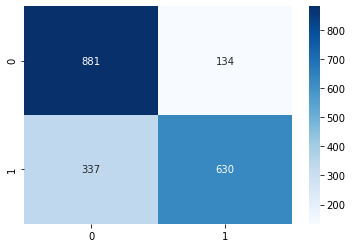

In [172]:
y_predict = rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_predict),annot=True, cmap='Blues',fmt='g');

#### Model Performance - Default Threshold

In [173]:
df_default = pd.DataFrame({
    "Index":['Accuracy','Recall','Precision','Average Precision','f1_score','roc_auc_score'],
    "Score_def_thresh":[
        accuracy_score(y_test, y_predict),
        recall_score(y_test, y_predict),
        precision_score(y_test, y_predict),
        average_precision_score(y_test, y_predict),
        f1_score(y_test, y_predict),
        roc_auc_score(y_test, y_predict)
    ]
    

})
df_default

,Index,Score_def_thresh
0,Accuracy,0.762361
1,Recall,0.651499
2,Precision,0.824607
3,Average Precision,0.707262
4,f1_score,0.727903
5,roc_auc_score,0.759740


#### ROC Curve

In [174]:
# Converting bool predictions into probabilities to draw ROC curve
y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

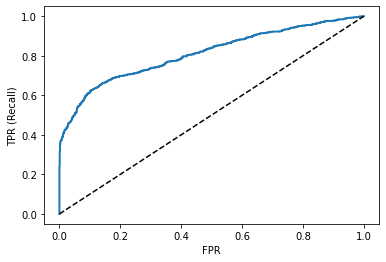

In [175]:
def plot_roc_curve(fpt, tpr,label = None):
    plt.plot(fpr, tpr, linewidth = 2, label =  label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR (Recall)')

plot_roc_curve(fpr, tpr)

In [176]:
# optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.5306997399756279


#### Re-evaluate predictions using optimal threshold

In [177]:
threshold = optimal_threshold

# predicted_proba = random_forest.predict_proba(X_test)
# y_prob
y_predict = (y_prob >= threshold).astype('int')

accuracy = accuracy_score(y_test, y_predict)

df_optimal = pd.DataFrame({
    "Score_optimal_thresh":[
        accuracy_score(y_test, y_predict),
        recall_score(y_test, y_predict),
        precision_score(y_test, y_predict),
        average_precision_score(y_test, y_predict),
        f1_score(y_test, y_predict),
        roc_auc_score(y_test, y_predict)
    ]
    

})
model_performance = pd.concat([df_default,df_optimal], axis = 1)
model_performance

,Index,Score_def_thresh,Score_optimal_thresh
0,Accuracy,0.762361,0.763875
1,Recall,0.651499,0.626680
2,Precision,0.824607,0.849930
3,Average Precision,0.707262,0.714774
4,f1_score,0.727903,0.721429
5,roc_auc_score,0.759740,0.760631


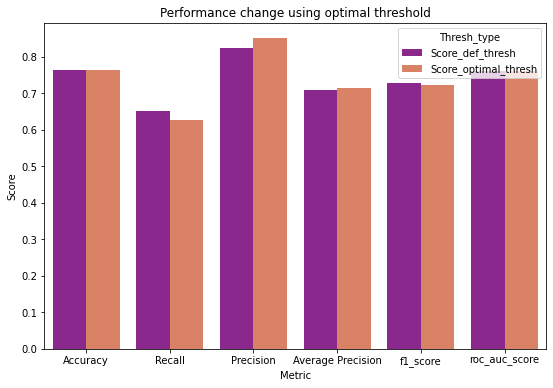

In [178]:
plt.figure(figsize=(9,6))
df_x = pd.melt(model_performance, id_vars='Index', value_vars=['Score_def_thresh', 'Score_optimal_thresh'])
# rename columns
df_x.rename(columns = {'Index':'Metric','variable':'Thresh_type','value':'Score'},inplace = True)
# plot results
sns.barplot(data = df_x, x = 'Metric', y = 'Score', hue = 'Thresh_type',palette='plasma')
plt.title('Performance change using optimal threshold');

Given the the default threshold is 0.5 and the optimal threhold is 0.53, there is very little improvement on the overall performance.  
This is not surprising since the dataset is evenly balanced.  
To improve the perforance, we will need to look to create new features that might provide additional information. 

In [60]:
# Top 7 most important features
for col, val in sorted(zip(X.columns, rf.feature_importances_),
key = lambda x: x[1],
reverse = True )[:7]:
    print(f"{col:10}{val:10.3f}")



total_spend_scaled     0.330
CryoSleep      0.257
age_scaled     0.103
HomePlanet_Earth     0.036
HomePlanet_Europa     0.034
group_size_scaled     0.030
cabin_side_P     0.018


#### Plotting precision and recall vs threholds

In [183]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

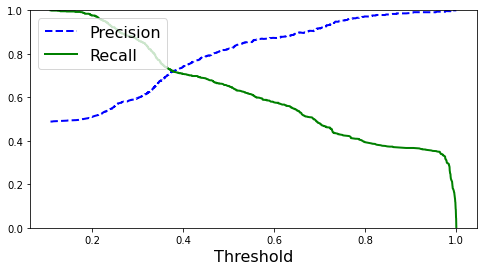

In [181]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

With this curve we can see that to archive the most even balance between Precision and Recall, the threshold should be set at about 0.4. However at this threshold the overall accuracy will drop. Given that the dataset is balanced, we can increase the Precision without sacrificing too much on Recall by setting the threshold at 0.53.

#### Precision vs Recall

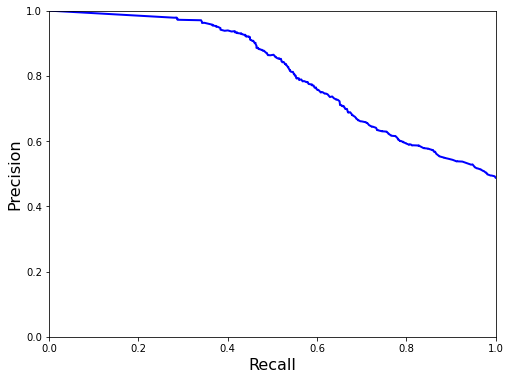

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

When plotting Precision and Recall against each other, we see that there is a gradual drop in precision as recall improves. Depending on our aim with this data (identify as many survivors as possible or be as targeted as possible), we can choose a different threshold. 
